In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import pandas as pd 
import math 
from tqdm import tqdm


In [2]:
from os import listdir
import cv2
import numpy as np

# Root Folder Name
FOLDER_NAME = 'Dataset'
# Class Folders
folders = listdir(FOLDER_NAME)
NR_CLASSES = len(folders)
# Walk over folders
data_X, data_Y = [], []
for i in range(NR_CLASSES):
    folder = folders[i]
    print('Folder', i+1, '-', folder)
    images = listdir(FOLDER_NAME + '/' + folder)
    # Walk over images
    for image in images:
        path = FOLDER_NAME + '/' + folder + '/' + image
        # Process Image
        raw = cv2.imread(path)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(gray, (32, 32))
        # Add to data
        data_X.append(img.flatten())
        data_Y.append(i)
# Convert to numpy arrays
X = np.array(data_X)
Y = np.array(data_Y).reshape([-1, 1])
# Verify sizes match
print('\nX and Y equal:', len(X) == len(Y))
print('Total training examples:', len(X))
print(X.shape)
print(Y.shape)

Folder 1 - basophil
Folder 2 - eosinophil
Folder 3 - erythroblast
Folder 4 - ig
Folder 5 - lymphocyte
Folder 6 - monocyte
Folder 7 - neutrophil
Folder 8 - platelet

X and Y equal: True
Total training examples: 17092
(17092, 1024)
(17092, 1)


In [3]:
def convolution(image, filt, bias, s=1):
    '''
    Confolves `filt` over `image` using stride `s`
    '''
    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    n_c, in_dim, _ = image.shape # image dimensions
    
    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
    
    # ensure that the filter dimensions match the dimensions of the input image
    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
    
    out = np.zeros((n_f,out_dim,out_dim)) # create the matrix to hold the values of the convolution operation
    
    # convolve each filter over the image
    for curr_f in range(n_f):
        curr_y = out_y = 0
        # move filter vertically across the image
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            # move filter horizontally across the image 
            while curr_x + f <= in_dim:
                # perform the convolution operation and add the bias
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        #print('Conv is working')
    return out

In [4]:
def maxpool(image, f=2, s=2):
    
    #Downsample input `image` using a kernel size of `f` and a stride of `s`
    
    n_c, h_prev, w_prev = image.shape
    
    # calculate output dimensions after the maxpooling operation.
    h = int((h_prev - f)/s)+1 
    w = int((w_prev - f)/s)+1
    
    # create a matrix to hold the values of the maxpooling operation.
    downsampled = np.zeros((n_c, h, w)) 
    
    # slide the window over every part of the image using stride s. Take the maximum value at each step.
    for i in range(n_c):
        curr_y = out_y = 0
        # slide the max pooling window vertically across the image
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            # slide the max pooling window horizontally across the image
            while curr_x + f <= w_prev:
                # choose the maximum value within the window at each step and store it to the output matrix
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    #print('max pooling is working')        
    return downsampled

In [5]:
def softmax(raw_preds):
    '''
    pass raw predictions through softmax activation function
    '''
    out = np.exp(raw_preds) # exponentiate vector of raw predictions
    return out/np.sum(out) # divide the exponentiated vector by its sum. All values in the output sum to 1.

In [6]:
def categoricalCrossEntropy(probs, label):
    '''
    calculate the categorical cross-entropy loss of the predictions
    '''
    return -np.sum(label * np.log(probs)) # Multiply the desired output label by the log of the prediction, then sum all values in the vector


In [7]:
def initializeFilter(size, scale = 1.0):
    '''
    Initialize filter using a normal distribution with and a 
    standard deviation inversely proportional the square root of the number of units
    '''
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

def initializeWeight(size):
    '''
    Initialize weights with a random normal distribution
    '''
    return np.random.standard_normal(size=size) * 0.01

In [8]:
def convolutionBackward(dconv_prev, conv_in, filt, s):
    '''
    Backpropagation through a convolutional layer. 
    '''
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias

def nanargmax(arr):
    '''
    return index of the largest non-nan value in the array. Output is an ordered pair tuple
    '''
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 

def maxpoolBackward(dpool, orig, f, s):
    '''
    Backpropagation through a maxpooling layer. The gradients are passed through the indices of greatest value in the original maxpooling during the forward step.
    '''
    (n_c, orig_dim, _) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window
                (a, b) = nanargmax(orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f])
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]
                
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return dout

In [9]:
def conv(image, label, params, conv_s, pool_f, pool_s):
    
    [f1, f2, w3, w4, b1, b2, b3, b4] = params 
    
    ################################################
    ############## Forward Operation ###############
    ################################################
    conv1 = convolution(image, f1, b1, conv_s) # convolution operation
    conv1[conv1<=0] = 0 # pass through ReLU non-linearity
    
    conv2 = convolution(conv1, f2, b2, conv_s) # second convolution operation
    conv2[conv2<=0] = 0 # pass through ReLU non-linearity
    
    pooled = maxpool(conv2, pool_f, pool_s) # maxpooling operation
    
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer
    
    z = w3.dot(fc) + b3 # first dense layer
    z[z<=0] = 0 # pass through ReLU non-linearity
    
    out = w4.dot(z) + b4 # second dense layer
     
    probs = softmax(out) # predict class probabilities with the softmax activation function
    
    ################################################
    #################### Loss ######################
    ################################################
    
    loss = categoricalCrossEntropy(probs, label) # categorical cross-entropy loss
        
    ################################################
    ############# Backward Operation ###############
    ################################################
    dout = probs - label # derivative of loss w.r.t. final dense layer output
    dw4 = dout.dot(z.T) # loss gradient of final dense layer weights
    db4 = np.sum(dout, axis = 1).reshape(b4.shape) # loss gradient of final dense layer biases
    
    dz = w4.T.dot(dout) # loss gradient of first dense layer outputs 
    dz[z<=0] = 0 # backpropagate through ReLU 
    dw3 = dz.dot(fc.T)
    db3 = np.sum(dz, axis = 1).reshape(b3.shape)
    
    dfc = w3.T.dot(dz) # loss gradients of fully-connected layer (pooling layer)
    dpool = dfc.reshape(pooled.shape) # reshape fully connected into dimensions of pooling layer
    
    dconv2 = maxpoolBackward(dpool, conv2, pool_f, pool_s) # backprop through the max-pooling layer(only neurons with highest activation in window get updated)
    dconv2[conv2<=0] = 0 # backpropagate through ReLU
    
    dconv1, df2, db2 = convolutionBackward(dconv2, conv1, f2, conv_s) # backpropagate previous gradient through second convolutional layer.
    dconv1[conv1<=0] = 0 # backpropagate through ReLU
    
    dimage, df1, db1 = convolutionBackward(dconv1, image, f1, conv_s) # backpropagate previous gradient through first convolutional layer.
    
    grads = [df1, df2, dw3, dw4, db1, db2, db3, db4] 
    
    return grads, loss

In [10]:
def adamGD(batch, num_classes, lr, dim, n_c, beta1, beta2, params, cost):
    '''
    update the parameters through Adam gradient descnet.
    '''
    [f1, f2, w3, w4, b1, b2, b3, b4] = params
    
    X = batch[:,0:-1] # get batch inputs
    X = X.reshape(len(batch), n_c, dim, dim)
    Y = batch[:,-1] # get batch labels
    
    cost_ = 0
    batch_size = len(batch)
    
    # initialize gradients and momentum,RMS params
    df1 = np.zeros(f1.shape)
    df2 = np.zeros(f2.shape)
    dw3 = np.zeros(w3.shape)
    dw4 = np.zeros(w4.shape)
    db1 = np.zeros(b1.shape)
    db2 = np.zeros(b2.shape)
    db3 = np.zeros(b3.shape)
    db4 = np.zeros(b4.shape)
    
    v1 = np.zeros(f1.shape)
    v2 = np.zeros(f2.shape)
    v3 = np.zeros(w3.shape)
    v4 = np.zeros(w4.shape)
    bv1 = np.zeros(b1.shape)
    bv2 = np.zeros(b2.shape)
    bv3 = np.zeros(b3.shape)
    bv4 = np.zeros(b4.shape)
    
    s1 = np.zeros(f1.shape)
    s2 = np.zeros(f2.shape)
    s3 = np.zeros(w3.shape)
    s4 = np.zeros(w4.shape)
    bs1 = np.zeros(b1.shape)
    bs2 = np.zeros(b2.shape)
    bs3 = np.zeros(b3.shape)
    bs4 = np.zeros(b4.shape)
    
    for i in range(batch_size):
        
        x = X[i]
        y = np.eye(num_classes)[int(Y[i])].reshape(num_classes, 1) # convert label to one-hot
        
        # Collect Gradients for training example
        grads, loss = conv(x, y, params, 1, 2, 2)
        [df1_, df2_, dw3_, dw4_, db1_, db2_, db3_, db4_] = grads
        
        df1+=df1_
        db1+=db1_
        df2+=df2_
        db2+=db2_
        dw3+=dw3_
        db3+=db3_
        dw4+=dw4_
        db4+=db4_

        cost_+= loss

    # Parameter Update  
        
    v1 = beta1*v1 + (1-beta1)*df1/batch_size # momentum update
    s1 = beta2*s1 + (1-beta2)*(df1/batch_size)**2 # RMSProp update
    f1 -= lr * v1/np.sqrt(s1+1e-7) # combine momentum and RMSProp to perform update with Adam
    
    bv1 = beta1*bv1 + (1-beta1)*db1/batch_size
    bs1 = beta2*bs1 + (1-beta2)*(db1/batch_size)**2
    b1 -= lr * bv1/np.sqrt(bs1+1e-7)
   
    v2 = beta1*v2 + (1-beta1)*df2/batch_size
    s2 = beta2*s2 + (1-beta2)*(df2/batch_size)**2
    f2 -= lr * v2/np.sqrt(s2+1e-7)
                       
    bv2 = beta1*bv2 + (1-beta1) * db2/batch_size
    bs2 = beta2*bs2 + (1-beta2)*(db2/batch_size)**2
    b2 -= lr * bv2/np.sqrt(bs2+1e-7)
    
    v3 = beta1*v3 + (1-beta1) * dw3/batch_size
    s3 = beta2*s3 + (1-beta2)*(dw3/batch_size)**2
    w3 -= lr * v3/np.sqrt(s3+1e-7)
    
    bv3 = beta1*bv3 + (1-beta1) * db3/batch_size
    bs3 = beta2*bs3 + (1-beta2)*(db3/batch_size)**2
    b3 -= lr * bv3/np.sqrt(bs3+1e-7)
    
    v4 = beta1*v4 + (1-beta1) * dw4/batch_size
    s4 = beta2*s4 + (1-beta2)*(dw4/batch_size)**2
    w4 -= lr * v4 / np.sqrt(s4+1e-7)
    
    bv4 = beta1*bv4 + (1-beta1)*db4/batch_size
    bs4 = beta2*bs4 + (1-beta2)*(db4/batch_size)**2
    b4 -= lr * bv4 / np.sqrt(bs4+1e-7)
    

    cost_ = cost_/batch_size
    cost.append(cost_)

    params = [f1, f2, w3, w4, b1, b2, b3, b4]
    #print ("parameters", params)
    #print ("f2", params[1])

    print ("Cost", cost)
    return params, cost

In [11]:
#####################################################
##################### Training ######################
#####################################################

def train(num_classes, lr, beta1, beta2, img_dim, img_depth, f, num_filt1, num_filt2, batch_size, num_epochs):

    # Get training data
    m =1000
    
    data = np.hstack((X,Y))

    np.random.shuffle(data)
    data_train = round(0.6*len(data))
    data_valid = round(data_train+0.2*len(data))
    train_x = X[:data_train]
    valid_x = X[data_train:data_valid]
    test_x = X[data_valid:]
    #train_data = data[:m]

    train_y = Y[:data_train]
    valid_y = Y[data_train:data_valid]
    test_y = Y[data_valid:]

    train_data = np.hstack((train_x,train_y))
    valid_data = np.hstack((valid_x,valid_y))
    test_data = np.hstack((test_x,test_y))

    #np.random.shuffle(train_data)
    #np.random.shuffle(valid_data)

    train_data = train_data[:m]
    valid_data = valid_data[:m]
    test_data = test_data[:m]


    ## Initializing all the parameters
    f1, f2, w3, w4 = (num_filt1 ,img_depth,f,f), (num_filt2 ,num_filt1,f,f), (128,720), (8, 128)
    f1 = initializeFilter(f1)
    f2 = initializeFilter(f2)
    w3 = initializeWeight(w3)
    w4 = initializeWeight(w4)

    b1 = np.zeros((f1.shape[0],1))
    b2 = np.zeros((f2.shape[0],1))
    b3 = np.zeros((w3.shape[0],1))
    b4 = np.zeros((w4.shape[0],1))

    params = [f1, f2, w3, w4, b1, b2, b3, b4]

    cost = []
    valid_cost = []
    test_cost = []

    print("LR:"+str(lr)+", Batch Size:"+str(batch_size))

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]

        np.random.shuffle(valid_data)
        batches1 = [valid_data[k:k + batch_size] for k in range(0, valid_data.shape[0], batch_size)]

        np.random.shuffle(test_data)
        batches2 = [test_data[k:k + batch_size] for k in range(0, test_data.shape[0], batch_size)]

        t = tqdm(batches)
        t1 = tqdm(batches1)
        t2 = tqdm(batches2)
        for x,batch in enumerate(t):
            params, cost = adamGD(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, cost)
            t.set_description("Cost: %.2f" % (cost[-1]))

        for x,batch in enumerate(t1):
            params1, valid_cost = adamGD(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, valid_cost)
            t1.set_description("Valid_Cost: %.2f" % (valid_cost[-1]))   
        
        for x,batch in enumerate(t2):
            params2, test_cost = adamGD(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, test_cost)
            t2.set_description("Test_Cost: %.2f" % (test_cost[-1]))
        
    print ("parameters", params)
    #print ("f2", params[1])


    
       
    return params, cost,valid_cost,test_cost

In [12]:
parameters,cost,valid_cost,test_cost = train(num_classes = 8, lr = 0.001, beta1 = 0.95, beta2 = 0.99, img_dim = 32, img_depth = 1, f = 5, num_filt1 = 8, num_filt2 = 5, batch_size = 100, num_epochs = 10)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

LR:0.001, Batch Size:100


Cost: 1.81:  10%|███████                                                                | 1/10 [01:02<09:25, 62.79s/it]

Cost [1.805058834099499]


Cost: 0.42:  20%|██████████████▏                                                        | 2/10 [02:14<08:44, 65.57s/it]

Cost [1.805058834099499, 0.41932456458767126]


Cost: 0.01:  30%|█████████████████████▎                                                 | 3/10 [03:20<07:40, 65.73s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025]


Cost: 0.00:  40%|████████████████████████████▍                                          | 4/10 [04:29<06:39, 66.59s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714]


Cost: 0.00:  50%|███████████████████████████████████▌                                   | 5/10 [05:32<05:27, 65.60s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05]


Cost: 0.00:  60%|██████████████████████████████████████████▌                            | 6/10 [06:38<04:22, 65.57s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05]


Cost: 0.00:  70%|█████████████████████████████████████████████████▋                     | 7/10 [07:44<03:17, 65.74s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05]


Cost: 0.00:  80%|████████████████████████████████████████████████████████▊              | 8/10 [08:51<02:12, 66.06s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05]


Cost: 0.00:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [09:57<01:05, 65.99s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05]


Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [11:04<00:00, 66.49s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05]




Valid_Cost: 12.61:  10%|██████                                                       | 1/10 [12:10<1:49:30, 730.03s/it]

Cost [12.613709885244726]



Valid_Cost: 6.13:  20%|████████████▍                                                 | 2/10 [13:16<1:10:46, 530.87s/it]

Cost [12.613709885244726, 6.129279193499976]



Valid_Cost: 1.90:  30%|███████████████████▏                                            | 3/10 [14:22<45:40, 391.47s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954]



Valid_Cost: 0.48:  40%|█████████████████████████▌                                      | 4/10 [15:28<29:23, 293.90s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419]



Valid_Cost: 0.06:  50%|████████████████████████████████                                | 5/10 [16:34<18:47, 225.57s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045]



Valid_Cost: 0.00:  60%|██████████████████████████████████████▍                         | 6/10 [17:41<11:51, 177.79s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057]



Valid_Cost: 0.00:  70%|████████████████████████████████████████████▊                   | 7/10 [18:48<07:13, 144.54s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571]



Valid_Cost: 0.00:  80%|███████████████████████████████████████████████████▏            | 8/10 [19:53<04:01, 120.69s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05]



Valid_Cost: 0.00:  90%|█████████████████████████████████████████████████████████▌      | 9/10 [20:58<01:44, 104.00s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05]



Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [22:04<00:00, 132.44s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05]





Test_Cost: 17.48:   0%|                                                                         | 0/10 [23:11<?, ?it/s]

Test_Cost: 17.48:  10%|██████                                                       | 1/10 [23:11<3:28:47, 1391.92s/it]

Cost [17.477931487658772]




Test_Cost: 11.48:  10%|██████                                                       | 1/10 [24:19<3:28:47, 1391.92s/it]

Test_Cost: 11.48:  20%|████████████▍                                                 | 2/10 [24:19<2:12:36, 994.53s/it]

Cost [17.477931487658772, 11.481349621096912]




Test_Cost: 7.24:  20%|████████████▌                                                  | 2/10 [25:20<2:12:36, 994.53s/it]

Test_Cost: 7.24:  30%|██████████████████▉                                            | 3/10 [25:20<1:23:22, 714.63s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186]




Test_Cost: 4.33:  30%|██████████████████▉                                            | 3/10 [26:22<1:23:22, 714.63s/it]

Test_Cost: 4.33:  40%|██████████████████████████                                       | 4/10 [26:22<51:52, 518.80s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674]




Test_Cost: 2.48:  40%|██████████████████████████                                       | 4/10 [27:25<51:52, 518.80s/it]

Test_Cost: 2.48:  50%|████████████████████████████████▌                                | 5/10 [27:25<31:49, 381.94s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143]




Test_Cost: 1.51:  50%|████████████████████████████████▌                                | 5/10 [28:27<31:49, 381.94s/it]

Test_Cost: 1.51:  60%|███████████████████████████████████████                          | 6/10 [28:27<19:03, 285.96s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377]




Test_Cost: 0.71:  60%|███████████████████████████████████████                          | 6/10 [29:28<19:03, 285.96s/it]

Test_Cost: 0.71:  70%|█████████████████████████████████████████████▌                   | 7/10 [29:28<10:55, 218.62s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137]




Test_Cost: 0.12:  70%|█████████████████████████████████████████████▌                   | 7/10 [30:30<10:55, 218.62s/it]

Test_Cost: 0.12:  80%|████████████████████████████████████████████████████             | 8/10 [30:30<05:43, 171.58s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017]




Test_Cost: 0.01:  80%|████████████████████████████████████████████████████             | 8/10 [31:32<05:43, 171.58s/it]

Test_Cost: 0.01:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [31:32<02:18, 138.68s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798]




Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [32:34<02:18, 138.68s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098]


Cost: 10.79:  10%|███████                                                               | 1/10 [01:01<09:15, 61.69s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965]


Cost: 6.92:  20%|██████████████▏                                                        | 2/10 [02:04<08:15, 61.92s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253]


Cost: 3.92:  30%|█████████████████████▎                                                 | 3/10 [03:08<07:18, 62.69s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216]


Cost: 2.03:  40%|████████████████████████████▍                                          | 4/10 [04:15<06:24, 64.07s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948]


Cost: 1.14:  50%|███████████████████████████████████▌                                   | 5/10 [05:21<05:23, 64.60s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638]


Cost: 0.57:  60%|██████████████████████████████████████████▌                            | 6/10 [06:28<04:21, 65.35s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191]


Cost: 0.19:  70%|█████████████████████████████████████████████████▋                     | 7/10 [07:30<03:12, 64.22s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973]


Cost: 0.04:  80%|████████████████████████████████████████████████████████▊              | 8/10 [08:31<02:06, 63.41s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987]


Cost: 0.00:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [09:33<01:02, 62.94s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834]


Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [10:36<00:00, 63.68s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294]




Valid_Cost: 12.18:  10%|██████                                                       | 1/10 [11:41<1:45:11, 701.24s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625]



Valid_Cost: 8.84:  20%|████████████▍                                                 | 2/10 [12:45<1:08:00, 510.07s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729]



Valid_Cost: 6.05:  30%|███████████████████▏                                            | 3/10 [13:49<43:54, 376.40s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761]



Valid_Cost: 3.72:  40%|█████████████████████████▌                                      | 4/10 [14:54<28:17, 282.93s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516]



Valid_Cost: 1.94:  50%|████████████████████████████████                                | 5/10 [15:58<18:06, 217.34s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511]



Valid_Cost: 0.84:  60%|██████████████████████████████████████▍                         | 6/10 [17:03<11:25, 171.38s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358]



Valid_Cost: 0.31:  70%|████████████████████████████████████████████▊                   | 7/10 [18:07<06:57, 139.28s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994]



Valid_Cost: 0.05:  80%|███████████████████████████████████████████████████▏            | 8/10 [19:11<03:53, 116.85s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282]



Valid_Cost: 0.00:  90%|█████████████████████████████████████████████████████████▌      | 9/10 [20:16<01:41, 101.03s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608]



Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [21:20<00:00, 128.02s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532]





Test_Cost: 11.29:   0%|                                                                         | 0/10 [22:24<?, ?it/s]

Test_Cost: 11.29:  10%|██████                                                       | 1/10 [22:24<3:21:43, 1344.87s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823]




Test_Cost: 7.16:  10%|██████▏                                                       | 1/10 [23:29<3:21:43, 1344.87s/it]

Test_Cost: 7.16:  20%|████████████▌                                                  | 2/10 [23:29<2:08:05, 960.69s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535]




Test_Cost: 3.96:  20%|████████████▌                                                  | 2/10 [24:33<2:08:05, 960.69s/it]

Test_Cost: 3.96:  30%|██████████████████▉                                            | 3/10 [24:33<1:20:41, 691.70s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046]




Test_Cost: 1.84:  30%|██████████████████▉                                            | 3/10 [25:38<1:20:41, 691.70s/it]

Test_Cost: 1.84:  40%|██████████████████████████                                       | 4/10 [25:38<50:22, 503.70s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996]




Test_Cost: 0.78:  40%|██████████████████████████                                       | 4/10 [26:41<50:22, 503.70s/it]

Test_Cost: 0.78:  50%|████████████████████████████████▌                                | 5/10 [26:41<30:58, 371.70s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726]




Test_Cost: 0.25:  50%|████████████████████████████████▌                                | 5/10 [27:46<30:58, 371.70s/it]

Test_Cost: 0.25:  60%|███████████████████████████████████████                          | 6/10 [27:46<18:38, 279.50s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637]




Test_Cost: 0.04:  60%|███████████████████████████████████████                          | 6/10 [28:50<18:38, 279.50s/it]

Test_Cost: 0.04:  70%|█████████████████████████████████████████████▌                   | 7/10 [28:50<10:44, 214.92s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725]




Test_Cost: 0.00:  70%|█████████████████████████████████████████████▌                   | 7/10 [29:55<10:44, 214.92s/it]

Test_Cost: 0.00:  80%|████████████████████████████████████████████████████             | 8/10 [29:55<05:39, 169.82s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257]




Test_Cost: 0.00:  80%|████████████████████████████████████████████████████             | 8/10 [30:59<05:39, 169.82s/it]

Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [30:59<02:18, 138.15s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934]




Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [32:03<02:18, 138.15s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05]


Cost: 13.94:  10%|███████                                                               | 1/10 [01:04<09:37, 64.19s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047]


Cost: 9.96:  20%|██████████████▏                                                        | 2/10 [02:08<08:32, 64.09s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028]


Cost: 6.76:  30%|█████████████████████▎                                                 | 3/10 [03:12<07:29, 64.17s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286]


Cost: 4.15:  40%|████████████████████████████▍                                          | 4/10 [04:16<06:25, 64.17s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824]


Cost: 2.27:  50%|███████████████████████████████████▌                                   | 5/10 [05:20<05:20, 64.12s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947]


Cost: 1.16:  60%|██████████████████████████████████████████▌                            | 6/10 [06:24<04:15, 63.98s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722]


Cost: 0.42:  70%|█████████████████████████████████████████████████▋                     | 7/10 [07:29<03:12, 64.25s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794]


Cost: 0.07:  80%|████████████████████████████████████████████████████████▊              | 8/10 [08:33<02:08, 64.31s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084]


Cost: 0.01:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [09:38<01:04, 64.39s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089]


Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [10:42<00:00, 64.23s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986]




Valid_Cost: 10.16:  10%|██████                                                       | 1/10 [11:46<1:46:01, 706.80s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617]



Valid_Cost: 6.84:  20%|████████████▍                                                 | 2/10 [12:51<1:08:32, 514.04s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115]



Valid_Cost: 4.23:  30%|███████████████████▏                                            | 3/10 [13:55<44:14, 379.15s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954]



Valid_Cost: 2.17:  40%|█████████████████████████▌                                      | 4/10 [15:00<28:28, 284.77s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886]



Valid_Cost: 0.92:  50%|████████████████████████████████                                | 5/10 [16:04<18:13, 218.65s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055]



Valid_Cost: 0.30:  60%|██████████████████████████████████████▍                         | 6/10 [17:08<11:29, 172.31s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543]



Valid_Cost: 0.05:  70%|████████████████████████████████████████████▊                   | 7/10 [18:12<06:59, 139.88s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455]



Valid_Cost: 0.00:  80%|███████████████████████████████████████████████████▏            | 8/10 [19:17<03:54, 117.31s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005]



Valid_Cost: 0.00:  90%|█████████████████████████████████████████████████████████▌      | 9/10 [20:22<01:41, 101.67s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851]



Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [21:25<00:00, 128.57s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05]





Test_Cost: 14.60:   0%|                                                                         | 0/10 [22:27<?, ?it/s]

Test_Cost: 14.60:  10%|██████                                                       | 1/10 [22:27<3:22:05, 1347.22s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547]




Test_Cost: 9.75:  10%|██████▏                                                       | 1/10 [23:28<3:22:05, 1347.22s/it]

Test_Cost: 9.75:  20%|████████████▌                                                  | 2/10 [23:28<2:08:12, 961.56s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924]




Test_Cost: 5.94:  20%|████████████▌                                                  | 2/10 [24:30<2:08:12, 961.56s/it]

Test_Cost: 5.94:  30%|██████████████████▉                                            | 3/10 [24:30<1:20:41, 691.68s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679]




Test_Cost: 3.10:  30%|██████████████████▉                                            | 3/10 [25:32<1:20:41, 691.68s/it]

Test_Cost: 3.10:  40%|██████████████████████████                                       | 4/10 [25:32<50:16, 502.69s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965]




Test_Cost: 1.30:  40%|██████████████████████████                                       | 4/10 [26:33<50:16, 502.69s/it]

Test_Cost: 1.30:  50%|████████████████████████████████▌                                | 5/10 [26:33<30:51, 370.24s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986]




Test_Cost: 0.67:  50%|████████████████████████████████▌                                | 5/10 [27:35<30:51, 370.24s/it]

Test_Cost: 0.67:  60%|███████████████████████████████████████                          | 6/10 [27:35<18:31, 277.75s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982]




Test_Cost: 0.17:  60%|███████████████████████████████████████                          | 6/10 [28:37<18:31, 277.75s/it]

Test_Cost: 0.17:  70%|█████████████████████████████████████████████▌                   | 7/10 [28:37<10:38, 212.93s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953]




Test_Cost: 0.01:  70%|█████████████████████████████████████████████▌                   | 7/10 [29:39<10:38, 212.93s/it]

Test_Cost: 0.01:  80%|████████████████████████████████████████████████████             | 8/10 [29:39<05:35, 167.59s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123]




Test_Cost: 0.00:  80%|████████████████████████████████████████████████████             | 8/10 [30:41<05:35, 167.59s/it]

Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [30:41<02:15, 135.96s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655]




Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [31:43<02:15, 135.96s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05]


Cost: 12.84:  10%|███████                                                               | 1/10 [01:01<09:17, 61.97s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864]


Cost: 8.20:  20%|██████████████▏                                                        | 2/10 [02:03<08:15, 61.96s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592]


Cost: 4.71:  30%|█████████████████████▎                                                 | 3/10 [03:05<07:13, 61.98s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516]


Cost: 2.43:  40%|████████████████████████████▍                                          | 4/10 [04:08<06:12, 62.01s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707]


Cost: 1.26:  50%|███████████████████████████████████▌                                   | 5/10 [05:09<05:09, 61.96s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097]


Cost: 0.71:  60%|██████████████████████████████████████████▌                            | 6/10 [06:11<04:07, 61.97s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223]


Cost: 0.18:  70%|█████████████████████████████████████████████████▋                     | 7/10 [07:13<03:06, 62.02s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914]


Cost: 0.01:  80%|████████████████████████████████████████████████████████▊              | 8/10 [08:16<02:04, 62.06s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953]


Cost: 0.00:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [09:17<01:01, 61.97s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945]


Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [10:19<00:00, 61.99s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05]




Valid_Cost: 12.51:  10%|██████                                                       | 1/10 [11:23<1:42:33, 683.69s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167]



Valid_Cost: 7.30:  20%|████████████▍                                                 | 2/10 [12:25<1:06:17, 497.24s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362]



Valid_Cost: 3.73:  30%|███████████████████▏                                            | 3/10 [13:27<42:46, 366.63s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157]



Valid_Cost: 1.86:  40%|█████████████████████████▌                                      | 4/10 [14:29<27:31, 275.29s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287]



Valid_Cost: 1.25:  50%|████████████████████████████████                                | 5/10 [15:32<17:36, 211.36s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253]



Valid_Cost: 0.75:  60%|██████████████████████████████████████▍                         | 6/10 [16:34<11:06, 166.68s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636]



Valid_Cost: 0.20:  70%|████████████████████████████████████████████▊                   | 7/10 [17:36<06:45, 135.33s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745]



Valid_Cost: 0.01:  80%|███████████████████████████████████████████████████▏            | 8/10 [18:38<03:46, 113.27s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311]



Valid_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [19:45<01:39, 99.39s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246]



Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [20:51<00:00, 125.20s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05]





Test_Cost: 14.97:   0%|                                                                         | 0/10 [21:57<?, ?it/s]

Test_Cost: 14.97:  10%|██████                                                       | 1/10 [21:57<3:17:35, 1317.29s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867]




Test_Cost: 9.16:  10%|██████▏                                                       | 1/10 [22:59<3:17:35, 1317.29s/it]

Test_Cost: 9.16:  20%|████████████▌                                                  | 2/10 [22:59<2:05:26, 940.82s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213]




Test_Cost: 4.90:  20%|████████████▌                                                  | 2/10 [24:01<2:05:26, 940.82s/it]

Test_Cost: 4.90:  30%|██████████████████▉                                            | 3/10 [24:01<1:19:00, 677.27s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905]




Test_Cost: 2.24:  30%|██████████████████▉                                            | 3/10 [25:03<1:19:00, 677.27s/it]

Test_Cost: 2.24:  40%|██████████████████████████                                       | 4/10 [25:03<49:16, 492.68s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395]




Test_Cost: 1.22:  40%|██████████████████████████                                       | 4/10 [26:06<49:16, 492.68s/it]

Test_Cost: 1.22:  50%|████████████████████████████████▌                                | 5/10 [26:06<30:17, 363.58s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751]




Test_Cost: 0.63:  50%|████████████████████████████████▌                                | 5/10 [27:08<30:17, 363.58s/it]

Test_Cost: 0.63:  60%|███████████████████████████████████████                          | 6/10 [27:08<18:12, 273.14s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754]




Test_Cost: 0.13:  60%|███████████████████████████████████████                          | 6/10 [28:10<18:12, 273.14s/it]

Test_Cost: 0.13:  70%|█████████████████████████████████████████████▌                   | 7/10 [28:10<10:29, 209.94s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417]




Test_Cost: 0.01:  70%|█████████████████████████████████████████████▌                   | 7/10 [29:16<10:29, 209.94s/it]

Test_Cost: 0.01:  80%|████████████████████████████████████████████████████             | 8/10 [29:16<05:33, 166.72s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263]




Test_Cost: 0.00:  80%|████████████████████████████████████████████████████             | 8/10 [30:23<05:33, 166.72s/it]

Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [30:23<02:16, 136.58s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042]




Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [31:29<02:16, 136.58s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05]


Cost: 15.01:  10%|███████                                                               | 1/10 [01:07<10:08, 67.59s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576]


Cost: 9.18:  20%|██████████████▏                                                        | 2/10 [02:18<09:09, 68.71s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147]


Cost: 5.02:  30%|█████████████████████▎                                                 | 3/10 [03:26<07:59, 68.49s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435]


Cost: 2.33:  40%|████████████████████████████▍                                          | 4/10 [04:32<06:45, 67.50s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211]


Cost: 1.18:  50%|███████████████████████████████████▌                                   | 5/10 [05:39<05:36, 67.35s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214]


Cost: 1.11:  60%|██████████████████████████████████████████▌                            | 6/10 [06:46<04:28, 67.23s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343]


Cost: 0.47:  70%|█████████████████████████████████████████████████▋                     | 7/10 [07:51<03:20, 66.76s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695]


Cost: 0.09:  80%|████████████████████████████████████████████████████████▊              | 8/10 [08:57<02:13, 66.57s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.00:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [10:03<01:06, 66.39s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [11:10<00:00, 67.02s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817



Valid_Cost: 13.64:  10%|██████                                                       | 1/10 [12:16<1:50:31, 736.84s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679]



Valid_Cost: 8.57:  20%|████████████▍                                                 | 2/10 [13:22<1:11:23, 535.45s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934]



Valid_Cost: 4.77:  30%|███████████████████▏                                            | 3/10 [14:28<46:03, 394.76s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352]



Valid_Cost: 2.32:  40%|█████████████████████████▌                                      | 4/10 [15:40<29:46, 297.73s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842]



Valid_Cost: 1.31:  50%|████████████████████████████████                                | 5/10 [16:47<19:02, 228.54s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954]



Valid_Cost: 1.22:  60%|██████████████████████████████████████▍                         | 6/10 [17:52<11:58, 179.52s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695]



Valid_Cost: 0.67:  70%|████████████████████████████████████████████▊                   | 7/10 [19:01<07:19, 146.44s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358]



Valid_Cost: 0.23:  80%|███████████████████████████████████████████████████▏            | 8/10 [20:15<04:09, 124.55s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802]



Valid_Cost: 0.03:  90%|█████████████████████████████████████████████████████████▌      | 9/10 [21:24<01:47, 107.90s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [22:32<00:00, 135.30s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0




Test_Cost: 16.56:   0%|                                                                         | 0/10 [23:43<?, ?it/s]

Test_Cost: 16.56:  10%|██████                                                       | 1/10 [23:43<3:33:28, 1423.15s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603]




Test_Cost: 10.31:  10%|██████                                                       | 1/10 [24:58<3:33:28, 1423.15s/it]

Test_Cost: 10.31:  20%|████████████▏                                                | 2/10 [24:58<2:15:50, 1018.80s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679]




Test_Cost: 5.81:  20%|████████████▍                                                 | 2/10 [26:15<2:15:50, 1018.80s/it]

Test_Cost: 5.81:  30%|██████████████████▉                                            | 3/10 [26:15<1:25:54, 736.34s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163]




Test_Cost: 2.98:  30%|██████████████████▉                                            | 3/10 [27:23<1:25:54, 736.34s/it]

Test_Cost: 2.98:  40%|██████████████████████████                                       | 4/10 [27:23<53:34, 535.82s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571]




Test_Cost: 1.55:  40%|██████████████████████████                                       | 4/10 [28:36<53:34, 535.82s/it]

Test_Cost: 1.55:  50%|████████████████████████████████▌                                | 5/10 [28:36<33:04, 396.89s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902]




Test_Cost: 1.35:  50%|████████████████████████████████▌                                | 5/10 [29:44<33:04, 396.89s/it]

Test_Cost: 1.35:  60%|███████████████████████████████████████                          | 6/10 [29:44<19:53, 298.38s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115]




Test_Cost: 0.79:  60%|███████████████████████████████████████                          | 6/10 [30:56<19:53, 298.38s/it]

Test_Cost: 0.79:  70%|█████████████████████████████████████████████▌                   | 7/10 [30:56<11:30, 230.30s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496]




Test_Cost: 0.26:  70%|█████████████████████████████████████████████▌                   | 7/10 [32:01<11:30, 230.30s/it]

Test_Cost: 0.26:  80%|████████████████████████████████████████████████████             | 8/10 [32:01<06:01, 180.71s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783]




Test_Cost: 0.02:  80%|████████████████████████████████████████████████████             | 8/10 [33:08<06:01, 180.71s/it]

Test_Cost: 0.02:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [33:08<02:26, 146.78s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [34:14<02:26, 146.78s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224

Cost: 13.29:  10%|███████                                                               | 1/10 [01:05<09:46, 65.17s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 8.30:  20%|██████████████▏                                                        | 2/10 [02:09<08:39, 65.00s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 4.58:  30%|█████████████████████▎                                                 | 3/10 [03:12<07:29, 64.26s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 2.27:  40%|████████████████████████████▍                                          | 4/10 [04:29<06:48, 68.10s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.24:  50%|███████████████████████████████████▌                                   | 5/10 [05:50<06:00, 72.01s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.22:  60%|██████████████████████████████████████████▌                            | 6/10 [07:05<04:51, 72.82s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.63:  70%|█████████████████████████████████████████████████▋                     | 7/10 [08:14<03:35, 71.80s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.21:  80%|████████████████████████████████████████████████████████▊              | 8/10 [09:32<02:26, 73.49s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.03:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [10:44<01:13, 73.27s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [12:16<00:00, 73.68s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817



Valid_Cost: 12.73:  10%|██████                                                       | 1/10 [13:43<2:03:33, 823.70s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 7.93:  20%|████████████▍                                                 | 2/10 [15:04<1:20:07, 600.92s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 4.52:  30%|███████████████████▏                                            | 3/10 [16:15<51:33, 441.92s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 2.38:  40%|█████████████████████████▌                                      | 4/10 [17:25<33:01, 330.22s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 1.30:  50%|████████████████████████████████                                | 5/10 [18:34<20:59, 251.81s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 1.24:  60%|██████████████████████████████████████▍                         | 6/10 [19:43<13:08, 197.14s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.68:  70%|████████████████████████████████████████████▊                   | 7/10 [20:51<07:54, 158.25s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.26:  80%|███████████████████████████████████████████████████▏            | 8/10 [22:03<04:25, 132.60s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.04:  90%|█████████████████████████████████████████████████████████▌      | 9/10 [23:15<01:54, 114.35s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [24:23<00:00, 146.34s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0




Test_Cost: 15.40:   0%|                                                                         | 0/10 [25:33<?, ?it/s]

Test_Cost: 15.40:  10%|██████                                                       | 1/10 [25:33<3:49:57, 1533.10s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 10.22:  10%|██████                                                       | 1/10 [27:02<3:49:57, 1533.10s/it]

Test_Cost: 10.22:  20%|████████████▏                                                | 2/10 [27:02<2:26:40, 1100.04s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 6.19:  20%|████████████▍                                                 | 2/10 [28:13<2:26:40, 1100.04s/it]

Test_Cost: 6.19:  30%|██████████████████▉                                            | 3/10 [28:13<1:32:18, 791.15s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 3.39:  30%|██████████████████▉                                            | 3/10 [29:14<1:32:18, 791.15s/it]

Test_Cost: 3.39:  40%|██████████████████████████                                       | 4/10 [29:14<57:12, 572.16s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 1.71:  40%|██████████████████████████                                       | 4/10 [30:15<57:12, 572.16s/it]

Test_Cost: 1.71:  50%|████████████████████████████████▌                                | 5/10 [30:15<34:53, 418.79s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 1.38:  50%|████████████████████████████████▌                                | 5/10 [31:26<34:53, 418.79s/it]

Test_Cost: 1.38:  60%|███████████████████████████████████████                          | 6/10 [31:26<20:57, 314.47s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.95:  60%|███████████████████████████████████████                          | 6/10 [32:44<20:57, 314.47s/it]

Test_Cost: 0.95:  70%|█████████████████████████████████████████████▌                   | 7/10 [32:44<12:10, 243.65s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.50:  70%|█████████████████████████████████████████████▌                   | 7/10 [34:03<12:10, 243.65s/it]

Test_Cost: 0.50:  80%|████████████████████████████████████████████████████             | 8/10 [34:03<06:28, 194.16s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.10:  80%|████████████████████████████████████████████████████             | 8/10 [35:18<06:28, 194.16s/it]

Test_Cost: 0.10:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [35:18<02:38, 158.45s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.01:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [36:31<02:38, 158.45s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224

Cost: 12.29:  10%|███████                                                               | 1/10 [01:08<10:15, 68.38s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 7.71:  20%|██████████████▏                                                        | 2/10 [02:18<09:10, 68.75s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 4.29:  30%|█████████████████████▎                                                 | 3/10 [03:35<08:19, 71.32s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 2.16:  40%|████████████████████████████▍                                          | 4/10 [04:51<07:16, 72.70s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.19:  50%|███████████████████████████████████▌                                   | 5/10 [06:12<06:16, 75.36s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.33:  60%|██████████████████████████████████████████▌                            | 6/10 [07:26<04:59, 74.85s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.68:  70%|█████████████████████████████████████████████████▋                     | 7/10 [08:40<03:43, 74.48s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.24:  80%|████████████████████████████████████████████████████████▊              | 8/10 [09:49<02:25, 72.95s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.03:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [11:04<01:13, 73.49s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [12:11<00:00, 73.11s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817



Valid_Cost: 13.56:  10%|██████                                                       | 1/10 [13:20<2:00:02, 800.25s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 8.82:  20%|████████████▍                                                 | 2/10 [14:38<1:17:48, 583.55s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 5.13:  30%|███████████████████▏                                            | 3/10 [15:57<50:25, 432.19s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 2.64:  40%|█████████████████████████▌                                      | 4/10 [17:06<32:19, 323.20s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 1.36:  50%|████████████████████████████████                                | 5/10 [18:23<20:47, 249.52s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 1.39:  60%|██████████████████████████████████████▍                         | 6/10 [19:24<12:52, 193.01s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.79:  70%|████████████████████████████████████████████▊                   | 7/10 [20:25<07:40, 153.39s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.33:  80%|███████████████████████████████████████████████████▏            | 8/10 [21:27<04:11, 125.83s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.04:  90%|█████████████████████████████████████████████████████████▌      | 9/10 [22:28<01:46, 106.49s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [23:29<00:00, 140.96s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0




Test_Cost: 18.12:   0%|                                                                         | 0/10 [24:31<?, ?it/s]

Test_Cost: 18.12:  10%|██████                                                       | 1/10 [24:31<3:40:39, 1471.06s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 11.46:  10%|██████                                                       | 1/10 [25:32<3:40:39, 1471.06s/it]

Test_Cost: 11.46:  20%|████████████▏                                                | 2/10 [25:32<2:19:44, 1048.12s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 6.55:  20%|████████████▍                                                 | 2/10 [26:33<2:19:44, 1048.12s/it]

Test_Cost: 6.55:  30%|██████████████████▉                                            | 3/10 [26:33<1:27:43, 751.91s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 3.33:  30%|██████████████████▉                                            | 3/10 [27:34<1:27:43, 751.91s/it]

Test_Cost: 3.33:  40%|██████████████████████████                                       | 4/10 [27:34<54:27, 544.66s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 1.68:  40%|██████████████████████████                                       | 4/10 [28:35<54:27, 544.66s/it]

Test_Cost: 1.68:  50%|████████████████████████████████▌                                | 5/10 [28:35<33:17, 399.54s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 1.41:  50%|████████████████████████████████▌                                | 5/10 [29:36<33:17, 399.54s/it]

Test_Cost: 1.41:  60%|███████████████████████████████████████                          | 6/10 [29:36<19:51, 297.98s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.90:  60%|███████████████████████████████████████                          | 6/10 [30:37<19:51, 297.98s/it]

Test_Cost: 0.90:  70%|█████████████████████████████████████████████▌                   | 7/10 [30:37<11:20, 226.92s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.25:  70%|█████████████████████████████████████████████▌                   | 7/10 [31:38<11:20, 226.92s/it]

Test_Cost: 0.25:  80%|████████████████████████████████████████████████████             | 8/10 [31:38<05:54, 177.23s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.02:  80%|████████████████████████████████████████████████████             | 8/10 [32:39<05:54, 177.23s/it]

Test_Cost: 0.02:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [32:39<02:22, 142.34s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [33:40<02:22, 142.34s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224

Cost: 14.29:  10%|███████                                                               | 1/10 [01:00<09:08, 60.99s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 8.63:  20%|██████████████▏                                                        | 2/10 [02:01<08:07, 60.97s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 4.58:  30%|█████████████████████▎                                                 | 3/10 [03:02<07:06, 60.94s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 2.06:  40%|████████████████████████████▍                                          | 4/10 [04:06<06:11, 61.89s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.14:  50%|███████████████████████████████████▌                                   | 5/10 [05:10<05:12, 62.42s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.81:  60%|██████████████████████████████████████████▌                            | 6/10 [06:14<04:11, 62.90s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.36:  70%|█████████████████████████████████████████████████▋                     | 7/10 [07:18<03:09, 63.22s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.07:  80%|████████████████████████████████████████████████████████▊              | 8/10 [08:22<02:07, 63.52s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.01:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [09:26<01:03, 63.59s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [10:30<00:00, 63.09s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817



Valid_Cost: 13.53:  10%|██████                                                       | 1/10 [11:35<1:44:17, 695.23s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 8.86:  20%|████████████▍                                                 | 2/10 [12:40<1:07:29, 506.13s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 5.36:  30%|███████████████████▏                                            | 3/10 [13:44<43:34, 373.50s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 2.94:  40%|█████████████████████████▌                                      | 4/10 [14:45<27:58, 279.80s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 1.52:  50%|████████████████████████████████                                | 5/10 [15:46<17:51, 214.21s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.93:  60%|██████████████████████████████████████▍                         | 6/10 [16:47<11:12, 168.13s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.56:  70%|████████████████████████████████████████████▊                   | 7/10 [17:48<06:48, 136.03s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.17:  80%|███████████████████████████████████████████████████▏            | 8/10 [18:51<03:48, 114.25s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.02:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [19:52<01:38, 98.34s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [20:54<00:00, 125.40s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0




Test_Cost: 19.24:   0%|                                                                         | 0/10 [21:55<?, ?it/s]

Test_Cost: 19.24:  10%|██████                                                       | 1/10 [21:55<3:17:20, 1315.66s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 13.06:  10%|██████                                                       | 1/10 [22:56<3:17:20, 1315.66s/it]

Test_Cost: 13.06:  20%|████████████▍                                                 | 2/10 [22:56<2:05:14, 939.26s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 8.37:  20%|████████████▌                                                  | 2/10 [23:58<2:05:14, 939.26s/it]

Test_Cost: 8.37:  30%|██████████████████▉                                            | 3/10 [23:58<1:18:52, 676.02s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 4.94:  30%|██████████████████▉                                            | 3/10 [24:59<1:18:52, 676.02s/it]

Test_Cost: 4.94:  40%|██████████████████████████                                       | 4/10 [24:59<49:09, 491.53s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 2.60:  40%|██████████████████████████                                       | 4/10 [26:01<49:09, 491.53s/it]

Test_Cost: 2.60:  50%|████████████████████████████████▌                                | 5/10 [26:01<30:12, 362.53s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 1.39:  50%|████████████████████████████████▌                                | 5/10 [27:02<30:12, 362.53s/it]

Test_Cost: 1.39:  60%|███████████████████████████████████████                          | 6/10 [27:02<18:08, 272.14s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 1.52:  60%|███████████████████████████████████████                          | 6/10 [28:03<18:08, 272.14s/it]

Test_Cost: 1.52:  70%|█████████████████████████████████████████████▌                   | 7/10 [28:03<10:26, 208.91s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.77:  70%|█████████████████████████████████████████████▌                   | 7/10 [29:04<10:26, 208.91s/it]

Test_Cost: 0.77:  80%|████████████████████████████████████████████████████             | 8/10 [29:04<05:29, 164.59s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.26:  80%|████████████████████████████████████████████████████             | 8/10 [30:06<05:29, 164.59s/it]

Test_Cost: 0.26:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [30:06<02:13, 133.69s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.02:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [31:07<02:13, 133.69s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224

Cost: 10.59:  10%|███████                                                               | 1/10 [01:01<09:14, 61.60s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 6.24:  20%|██████████████▏                                                        | 2/10 [02:02<08:11, 61.38s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 3.23:  30%|█████████████████████▎                                                 | 3/10 [03:03<07:09, 61.41s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.63:  40%|████████████████████████████▍                                          | 4/10 [04:04<06:07, 61.30s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.52:  50%|███████████████████████████████████▌                                   | 5/10 [05:06<05:06, 61.23s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.98:  60%|██████████████████████████████████████████▌                            | 6/10 [06:07<04:04, 61.15s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.53:  70%|█████████████████████████████████████████████████▋                     | 7/10 [07:08<03:03, 61.15s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.12:  80%|████████████████████████████████████████████████████████▊              | 8/10 [08:09<02:02, 61.09s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.01:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [09:10<01:01, 61.08s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [10:11<00:00, 61.10s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817



Valid_Cost: 14.16:  10%|██████                                                       | 1/10 [11:12<1:40:50, 672.29s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 9.21:  20%|████████████▍                                                 | 2/10 [12:13<1:05:12, 489.08s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 5.43:  30%|███████████████████▏                                            | 3/10 [13:15<42:05, 360.76s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 2.83:  40%|█████████████████████████▌                                      | 4/10 [14:16<27:05, 270.88s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 1.37:  50%|████████████████████████████████                                | 5/10 [15:17<17:19, 207.92s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.99:  60%|██████████████████████████████████████▍                         | 6/10 [16:18<10:55, 163.89s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.56:  70%|████████████████████████████████████████████▊                   | 7/10 [17:19<06:39, 133.13s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.15:  80%|███████████████████████████████████████████████████▏            | 8/10 [18:21<03:43, 111.67s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.01:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [19:22<01:36, 96.51s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [20:24<00:00, 122.42s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0




Test_Cost: 19.15:   0%|                                                                         | 0/10 [21:25<?, ?it/s]

Test_Cost: 19.15:  10%|██████                                                       | 1/10 [21:25<3:12:46, 1285.13s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 13.08:  10%|██████                                                       | 1/10 [22:26<3:12:46, 1285.13s/it]

Test_Cost: 13.08:  20%|████████████▍                                                 | 2/10 [22:26<2:02:23, 917.98s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 8.19:  20%|████████████▌                                                  | 2/10 [23:27<2:02:23, 917.98s/it]

Test_Cost: 8.19:  30%|██████████████████▉                                            | 3/10 [23:27<1:17:06, 660.95s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 4.51:  30%|██████████████████▉                                            | 3/10 [24:28<1:17:06, 660.95s/it]

Test_Cost: 4.51:  40%|██████████████████████████                                       | 4/10 [24:28<48:06, 481.06s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 2.11:  40%|██████████████████████████                                       | 4/10 [25:29<48:06, 481.06s/it]

Test_Cost: 2.11:  50%|████████████████████████████████▌                                | 5/10 [25:29<29:35, 355.03s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 1.29:  50%|████████████████████████████████▌                                | 5/10 [26:30<29:35, 355.03s/it]

Test_Cost: 1.29:  60%|███████████████████████████████████████                          | 6/10 [26:30<17:47, 266.82s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.99:  60%|███████████████████████████████████████                          | 6/10 [27:31<17:47, 266.82s/it]

Test_Cost: 0.99:  70%|█████████████████████████████████████████████▌                   | 7/10 [27:31<10:15, 205.07s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.85:  70%|█████████████████████████████████████████████▌                   | 7/10 [28:33<10:15, 205.07s/it]

Test_Cost: 0.85:  80%|████████████████████████████████████████████████████             | 8/10 [28:33<05:23, 161.95s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.22:  80%|████████████████████████████████████████████████████             | 8/10 [29:34<05:23, 161.95s/it]

Test_Cost: 0.22:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [29:34<02:11, 131.74s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.01:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [30:35<02:11, 131.74s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224

Cost: 12.26:  10%|███████                                                               | 1/10 [01:00<09:08, 60.93s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 7.06:  20%|██████████████▏                                                        | 2/10 [02:01<08:07, 60.97s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 3.36:  30%|█████████████████████▎                                                 | 3/10 [03:03<07:08, 61.14s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.54:  40%|████████████████████████████▍                                          | 4/10 [04:04<06:07, 61.19s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.79:  50%|███████████████████████████████████▌                                   | 5/10 [05:05<05:05, 61.06s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 1.14:  60%|██████████████████████████████████████████▌                            | 6/10 [06:06<04:04, 61.12s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.78:  70%|█████████████████████████████████████████████████▋                     | 7/10 [07:07<03:03, 61.02s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.27:  80%|████████████████████████████████████████████████████████▊              | 8/10 [08:08<02:02, 61.08s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.02:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [09:10<01:01, 61.20s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817

Cost: 0.00: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [10:11<00:00, 61.17s/it]

Cost [1.805058834099499, 0.41932456458767126, 0.014087307350374025, 0.0001692433711427714, 5.653639294561886e-05, 3.356158175112585e-05, 2.396809661747693e-05, 1.9735546402678084e-05, 1.5763080920937223e-05, 1.3486385941374477e-05, 10.794958456889965, 6.921550221291253, 3.9205335028904216, 2.0339443569756948, 1.1359513374314638, 0.5665828764235191, 0.18895635398112973, 0.03744538130653987, 0.0041888964860639834, 0.0004988327741898294, 13.936540459613047, 9.96470549480028, 6.759911915500286, 4.147051321106824, 2.2729482942453947, 1.1610517082172722, 0.42251486776857794, 0.07469555281327084, 0.006418318407235089, 0.0005783703895562986, 12.836280793449864, 8.198480580402592, 4.708526150373516, 2.427440691808707, 1.259752148916097, 0.7081402542711223, 0.18073413084663914, 0.010133898370896953, 0.00024371080452472945, 2.753302081775263e-05, 15.011368842088576, 9.177649407984147, 5.024211633891435, 2.325921674059211, 1.181703919301214, 1.1140912177270343, 0.47171258927469695, 0.0895473618817



Valid_Cost: 15.38:  10%|██████                                                       | 1/10 [11:14<1:41:06, 674.04s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 9.67:  20%|████████████▍                                                 | 2/10 [12:15<1:05:21, 490.25s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 5.37:  30%|███████████████████▏                                            | 3/10 [13:16<42:10, 361.46s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 2.52:  40%|█████████████████████████▌                                      | 4/10 [14:17<27:08, 271.47s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 1.18:  50%|████████████████████████████████                                | 5/10 [15:18<17:21, 208.34s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 1.43:  60%|██████████████████████████████████████▍                         | 6/10 [16:20<10:56, 164.22s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.62:  70%|████████████████████████████████████████████▊                   | 7/10 [17:21<06:39, 133.22s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.16:  80%|███████████████████████████████████████████████████▏            | 8/10 [18:22<03:43, 111.67s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.01:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [19:23<01:36, 96.53s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0


Valid_Cost: 0.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [20:25<00:00, 122.53s/it]

Cost [12.613709885244726, 6.129279193499976, 1.9015729174187954, 0.4830742251328419, 0.059338604989321045, 0.0038545933766283057, 0.0003906240788377571, 9.15193451790838e-05, 3.919789094803865e-05, 2.5649834936594426e-05, 12.178118574525625, 8.83741414768729, 6.049341830583761, 3.717224841972516, 1.9367038000870511, 0.8429194833112358, 0.30925509649505994, 0.04688601036105282, 0.0031951087833463608, 0.0002975351746294532, 10.164771032014617, 6.8418420870715115, 4.228511992749954, 2.1664902232317886, 0.9171980347453055, 0.30422177998973543, 0.04735792114029455, 0.003021321679140005, 0.00022974909030712851, 4.913693756712343e-05, 12.514925977767167, 7.29940279102362, 3.7328417861479157, 1.8574271610449287, 1.2512844870644253, 0.74797770705636, 0.19659836765481745, 0.01166647408039311, 0.00030943374139103246, 2.9783938119770803e-05, 13.64446580618679, 8.573609685349934, 4.771710095712352, 2.3176120400710842, 1.3147699935605954, 1.2236189226704695, 0.667521883160358, 0.23163752914868802, 0




Test_Cost: 19.10:   0%|                                                                         | 0/10 [21:26<?, ?it/s]

Test_Cost: 19.10:  10%|██████                                                       | 1/10 [21:26<3:12:58, 1286.45s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 12.50:  10%|██████                                                       | 1/10 [22:27<3:12:58, 1286.45s/it]

Test_Cost: 12.50:  20%|████████████▍                                                 | 2/10 [22:27<2:02:30, 918.87s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 7.31:  20%|████████████▌                                                  | 2/10 [23:29<2:02:30, 918.87s/it]

Test_Cost: 7.31:  30%|██████████████████▉                                            | 3/10 [23:29<1:17:11, 661.69s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 3.46:  30%|██████████████████▉                                            | 3/10 [24:30<1:17:11, 661.69s/it]

Test_Cost: 3.46:  40%|██████████████████████████                                       | 4/10 [24:30<48:10, 481.69s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 1.45:  40%|██████████████████████████                                       | 4/10 [25:32<48:10, 481.69s/it]

Test_Cost: 1.45:  50%|████████████████████████████████▌                                | 5/10 [25:32<29:37, 355.51s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 1.76:  50%|████████████████████████████████▌                                | 5/10 [26:33<29:37, 355.51s/it]

Test_Cost: 1.76:  60%|███████████████████████████████████████                          | 6/10 [26:33<17:49, 267.29s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.95:  60%|███████████████████████████████████████                          | 6/10 [27:34<17:49, 267.29s/it]

Test_Cost: 0.95:  70%|█████████████████████████████████████████████▌                   | 7/10 [27:34<10:16, 205.39s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.40:  70%|█████████████████████████████████████████████▌                   | 7/10 [28:35<10:16, 205.39s/it]

Test_Cost: 0.40:  80%|████████████████████████████████████████████████████             | 8/10 [28:35<05:24, 162.22s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.04:  80%|████████████████████████████████████████████████████             | 8/10 [29:36<05:24, 162.22s/it]

Test_Cost: 0.04:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [29:36<02:11, 131.82s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224



Test_Cost: 0.00:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [30:38<02:11, 131.82s/it]

Test_Cost: 0.00: 100%|████████████████████████████████████████████████████████████████| 10/10 [30:38<00:00, 183.80s/it]

Cost [17.477931487658772, 11.481349621096912, 7.2365141576138186, 4.329902826767674, 2.4760411291537143, 1.5138635182223377, 0.7073556751685137, 0.12401734248441017, 0.007844180439016798, 0.0004556797310312098, 11.286471904239823, 7.1580123306771535, 3.9571610125268046, 1.8399116118774996, 0.7802855169740726, 0.2489798442024637, 0.040478171647824725, 0.0034103101165470257, 0.0003388346063951934, 8.207387633336027e-05, 14.600696001489547, 9.75421890186924, 5.943346249809679, 3.104772795184965, 1.3028420971721986, 0.6716637475518982, 0.17394469785564953, 0.013044275982573123, 0.00042176041655823655, 5.277390877793245e-05, 14.972619765065867, 9.155213669572213, 4.903756139238905, 2.2431711694723395, 1.2247738678146751, 0.6327003039336754, 0.13385226554640417, 0.006069226684909263, 0.00017053570314741042, 1.8954303310665997e-05, 16.557461094319603, 10.312316690749679, 5.807679969784163, 2.978874251521571, 1.5495151527915902, 1.351094254483115, 0.7920496809535496, 0.2575269765176783, 0.0224

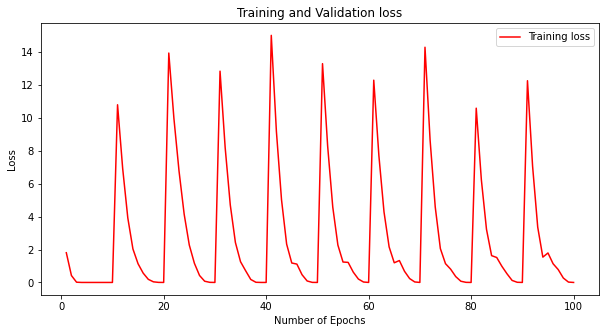

In [17]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,101)
plt.plot(epochs, cost, 'r', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

    

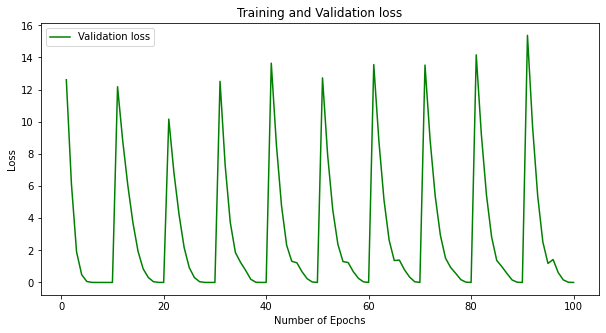

In [50]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,101)
plt.plot(epochs, valid_cost, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

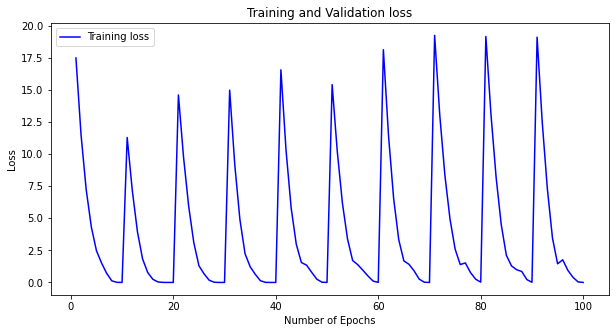

In [19]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,101)
plt.plot(epochs, test_cost, 'b', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

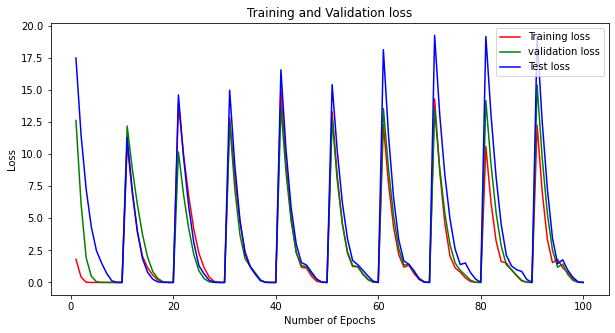

In [20]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,101)
plt.plot(epochs, cost, 'r', label='Training loss')
plt.plot(epochs, valid_cost, 'g', label='validation loss')
plt.plot(epochs, test_cost, 'b', label='Test loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

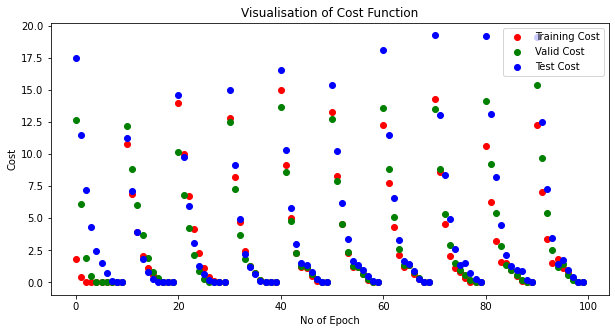

In [21]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
ax1.scatter(x=list(range(0,100)),y=cost,color='red',label='Training Cost')
ax1.scatter(x=list(range(0,100)),y=valid_cost,color='green',label='Valid Cost')
ax1.scatter(x=list(range(0,100)),y=test_cost,color='blue',label='Test Cost')
plt.xlabel('No of Epoch')
plt.ylabel('Cost')
plt.title('Visualisation of Cost Function')
plt.legend()
plt.show()

In [22]:
parameters = list(parameters)

In [23]:
parameters[1].shape

(5, 8, 5, 5)

In [24]:
parameters[0].shape

(8, 1, 5, 5)

In [25]:
parameters[2].shape

(128, 720)

In [26]:
type(parameters)

list

In [27]:
parameters[2].dtype

dtype('float64')

In [28]:
image = cv2.imread('MO_2221.jpg',0)

In [29]:
image= cv2.resize(image,(32,32),interpolation = cv2.INTER_AREA)

In [30]:
type(image)

numpy.ndarray

In [31]:
image.shape

(32, 32)

In [32]:
image=np.reshape(image, (1,32,32))

In [33]:
image.shape

(1, 32, 32)

In [34]:
def test(image, label, params, conv_s, pool_f, pool_s):
    
    [f1, f2, w3, w4, b1, b2, b3, b4] = params 
    
    ################################################
    ############## Forward Operation ###############
    ################################################
    conv1 = convolution(image, f1, b1, conv_s) # convolution operation
    conv1[conv1<=0] = 0 # pass through ReLU non-linearity
    
    conv2 = convolution(conv1, f2, b2, conv_s) # second convolution operation
    conv2[conv2<=0] = 0 # pass through ReLU non-linearity
    
    pooled = maxpool(conv2, pool_f, pool_s) # maxpooling operation
    
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer
    
    z = w3.dot(fc) + b3 # first dense layer
    z[z<=0] = 0 # pass through ReLU non-linearity
    
    out = w4.dot(z) + b4 # second dense layer
     
    probs = softmax(out) # predict class probabilities with the softmax activation function
    
    ################################################
    #################### Loss ######################
    ################################################
    
    loss = categoricalCrossEntropy(probs, label) # categorical cross-entropy loss
        
        
    return probs, loss

In [35]:
prediction,loss = test(image, label=8, params = parameters, conv_s=1, pool_f=2, pool_s=2)

In [36]:
prediction

array([[6.12800894e-07],
       [5.66312297e-15],
       [2.96423838e-15],
       [1.41468261e-15],
       [3.44261275e-15],
       [8.96967416e-05],
       [9.99909690e-01],
       [3.63900761e-16]])

In [37]:
max(prediction)

array([0.99990969])

In [38]:
loss

1543.403333686526

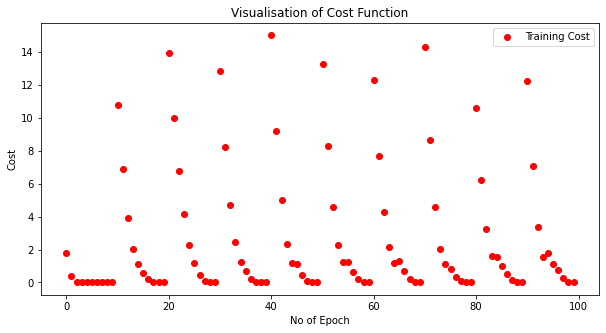

In [39]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
ax1.scatter(x=list(range(0,100)),y=cost,color='red',label='Training Cost')

plt.xlabel('No of Epoch')
plt.ylabel('Cost')
plt.title('Visualisation of Cost Function')
plt.legend()
plt.show()

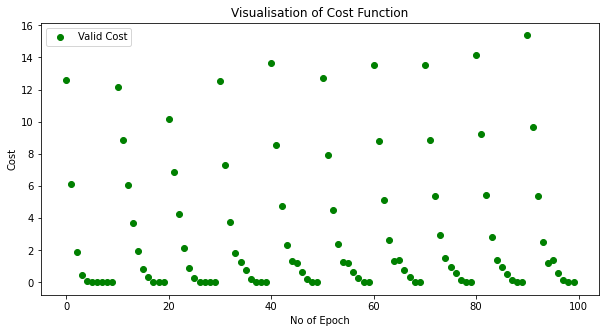

In [40]:

fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)

ax1.scatter(x=list(range(0,100)),y=valid_cost,color='green',label='Valid Cost')

plt.xlabel('No of Epoch')
plt.ylabel('Cost')
plt.title('Visualisation of Cost Function')
plt.legend()
plt.show()

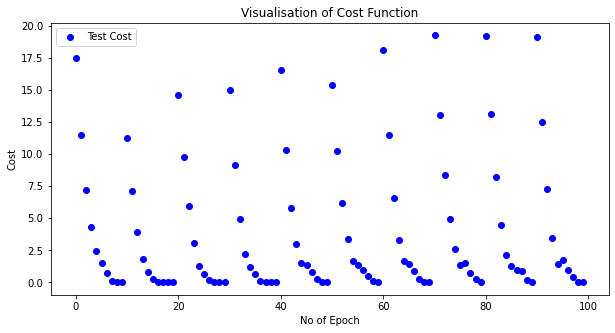

In [41]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)

ax1.scatter(x=list(range(0,100)),y=test_cost,color='blue',label='Test Cost')
plt.xlabel('No of Epoch')
plt.ylabel('Cost')
plt.title('Visualisation of Cost Function')
plt.legend()
plt.show()

In [42]:
c = cost[:10]

[1.805058834099499,
 0.41932456458767126,
 0.014087307350374025,
 0.0001692433711427714,
 5.653639294561886e-05,
 3.356158175112585e-05,
 2.396809661747693e-05,
 1.9735546402678084e-05,
 1.5763080920937223e-05,
 1.3486385941374477e-05]

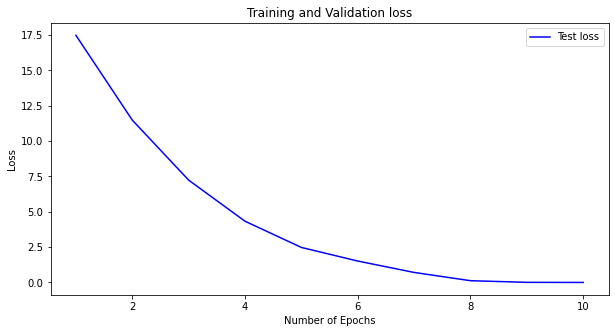

In [48]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,11)
plt.plot(epochs, test_cost[:10], 'b', label='Test loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

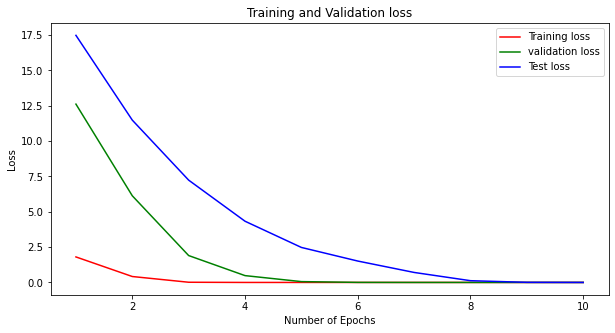

In [46]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,11)
plt.plot(epochs, cost[:10], 'r', label='Training loss')
plt.plot(epochs, valid_cost[:10], 'g', label='validation loss')
plt.plot(epochs, test_cost[:10], 'b', label='Test loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

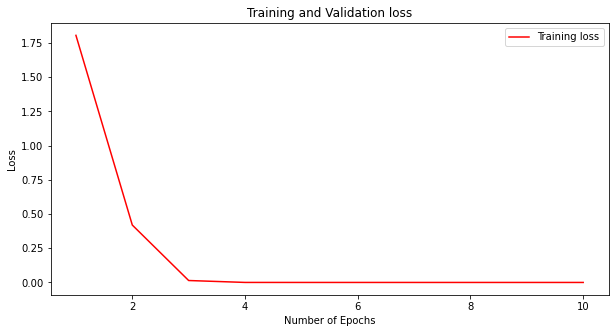

In [49]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,11)
plt.plot(epochs, cost[:10], 'r', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

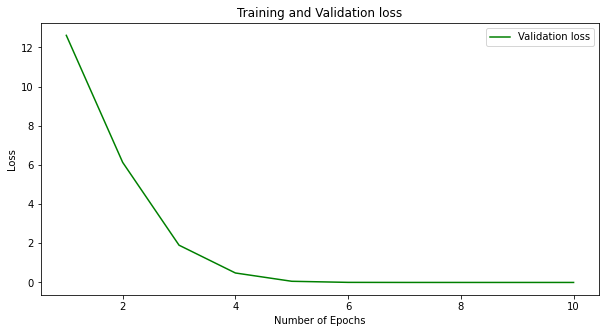

In [51]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,11)
plt.plot(epochs, valid_cost[:10], 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [2]:
cost

NameError: name 'cost' is not defined